## パッケージ導入

In [19]:
!pip install --upgrade google-genai japanize_matplotlib

In [20]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## 事前準備

In [1]:
import vertexai
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
LOCATION = 'us-central1'

vertexai.init(project=PROJECT_ID, location='us-central1')

BUCKET = f'gs://{PROJECT_ID}-handson'

In [2]:
target_s = f'{BUCKET}/mp4/s_千葉県印西市にデータセンターを開設.mp4'
target_n = f'{BUCKET}/mp4/n_千葉県印西市にデータセンターを開設.mp4'

In [23]:
import base64, copy, json, os, re, time, uuid
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image

import vertexai
from google.cloud import storage
from google import genai
from google.genai import types
from google.genai.types import (
    HttpOptions, GenerateContentConfig, GenerateImagesConfig,
    Part, UserContent, ModelContent,
)

import os, json, datetime, pprint
import numpy as np

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

In [4]:
def generate_response(system_instruction, contents,
                      response_schema, model='gemini-2.0-flash-001'):
    client = genai.Client(vertexai=True,
                          project=PROJECT_ID, location=LOCATION,
                          http_options=HttpOptions(api_version='v1'))
    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=GenerateContentConfig(
            system_instruction=system_instruction,
            temperature=0.1,
            response_mime_type='application/json',
            response_schema=response_schema,
        )
    )
    return '\n'.join(
        [p.text for p in response.candidates[0].content.parts if p.text]
    )

In [5]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

In [6]:
!gsutil ls -l {BUCKET}/mp4/s*

  24857097  2025-02-03T02:33:52Z  gs://movie-search-metadeta-test-handson/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4
   5514908  2025-02-03T02:33:50Z  gs://movie-search-metadeta-test-handson/mp4/s_千葉県印西市にデータセンターを開設.mp4
  30815449  2025-02-03T02:33:51Z  gs://movie-search-metadeta-test-handson/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4
TOTAL: 3 objects, 61187454 bytes (58.35 MiB)


**注意**

次のコマンドを実行するとプロジェクト内でキャッシュ中のデータをすべて削除できます。

キャッシュ中のデータに対する不要な課金を避けるために、検証が完了したら実行しておくことをお勧めします。

```
for item in caching.CachedContent.list():
    cached_content = caching.CachedContent(
        f'projects/{item.project}/locations/{item.location}/cachedContents/{item.name}')
    cached_content.delete()
```

In [7]:
filename = target_s.split('/')[-1]
basename = filename.rstrip('.mp4').lstrip('s_')
image_dir = f'{BUCKET}/image/{basename}'
gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
local_image_dir = basename

In [ ]:
# 静止画像ファイルをローカルにコピー
!gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

## キャラクター抽出

In [25]:
system_instruction = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find characters in the movie and describe the visual appearance of each character as detailed as possible.
B. Identify the name of each character you found on task A. If you cannot identify the name, name it "Unknown".
C. Identify representative scenes for each character where the character visually appears on the screen.

[condition]
B. The description has more than three sentences.
C. The number of scenes for each character is at most three. Each scene is identified with timestamp mm:ss-mm:ss.

[format instruction]
In Japanese. Output is a JSON list of "character dict". "character dict" is a JSON dict in the following format:
{
  "Character ID": <Sequential number starting from 1>,
  "Name": "<Character name>",
  "Visual Description": "<Visual appearance>",
  "Scenes": [ "<list of timestamp of representative scenes>" ]
}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Character ID": {"type": "string",
                                 "description": "Sequential number starting from 1"
                },
                "Name" : {"type": "string",
                          "description": "Character name"
                },
                "Visual Description": {"type": "string",
                                       "description": "Visual appearance of the character"
                },
                "Scenes": {"type": "array",
                           "items": {
                              "type": "string"
                           },
                           "description": "list of timestamp of representative scenes"
                },
            },
            "required": [
                "Character ID",
                "Name",
                "Visual Description",
                "Scenes"
            ],

    }
}

In [26]:
contents = UserContent([
    Part.from_text(text='[movie]'),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Character ID": "1",
    "Name": "金井 匡彦",
    "Visual Description": "彼はアジア系の男性で、短めの黒髪をしています。肌は明るく、穏やかな表情をしています。彼は白いTシャツを着ており、そのTシャツには青い波の模様がプリントされています。背景にはGoogleのロゴが見えます。",
    "Scenes": [
      "00:00-00:01",
      "00:08-00:11",
      "02:22-02:25"
    ]
  },
  {
    "Character ID": "2",
    "Name": "ルイス イワノフ",
    "Visual Description": "彼女は白人系の女性で、肩までの長さの茶色の髪をしています。彼女は明るい肌色で、穏やかな笑顔を浮かべています。彼女は白いトップスの上に黒いカーディガンを着ており、ベージュのスカートを履いています。背景には工業的な設備が見えます。",
    "Scenes": [
      "00:41-00:44",
      "00:50-00:52",
      "01:03-01:06"
    ]
  },
  {
    "Character ID": "3",
    "Name": "高橋 駿",
    "Visual Description": "彼はアジア系の男性で、非常に特徴的な髪型をしています。髪の半分は青色、もう半分は赤色に染められています。彼は黒いTシャツを着ており、Google Cloudのロゴが入っています。彼は会議室のような場所に座っています。",
    "Scenes": [
      "01:27-01:30",
      "01:43-01:45",
      "01:45-01:50"
    ]
  },
  {
    "Character ID": "4",
    "Name": "レオ ギャラモン",
    "Visual Description": "彼は黒人系の男性で、短く整えられた髪と髭を持っています。彼は眼鏡をかけており、穏やかな表情をしています。彼は黒いポロシャツを着ており、胸にはロゴが入っています。彼はオフィスの

=====
1 金井 匡彦 彼はアジア系の男性で、短めの黒髪をしています。肌は明るく、穏やかな表情をしています。彼は白いTシャツを着ており、そのTシャツには青い波の模様がプリントされています。背景にはGoogleのロゴが見えます。


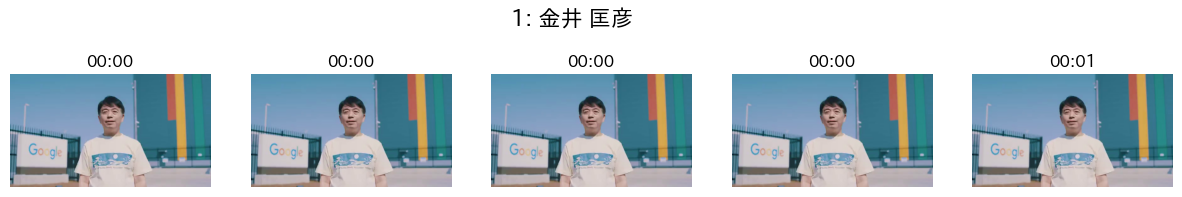

<Figure size 640x480 with 0 Axes>

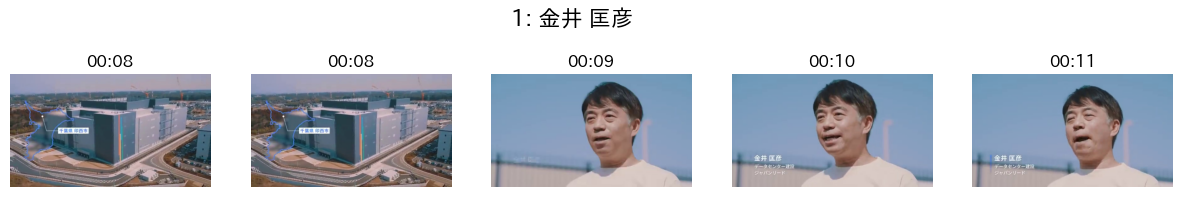

<Figure size 640x480 with 0 Axes>

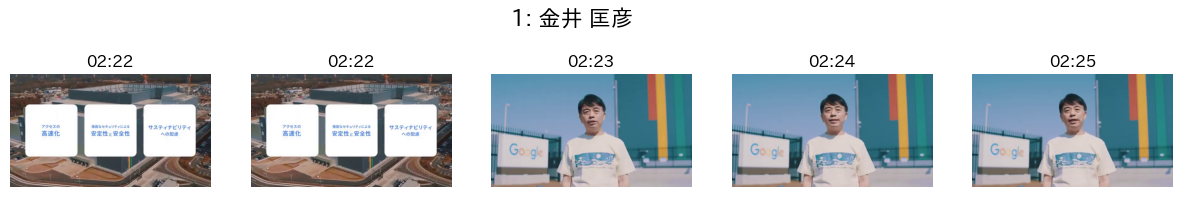

=====
2 ルイス イワノフ 彼女は白人系の女性で、肩までの長さの茶色の髪をしています。彼女は明るい肌色で、穏やかな笑顔を浮かべています。彼女は白いトップスの上に黒いカーディガンを着ており、ベージュのスカートを履いています。背景には工業的な設備が見えます。


<Figure size 640x480 with 0 Axes>

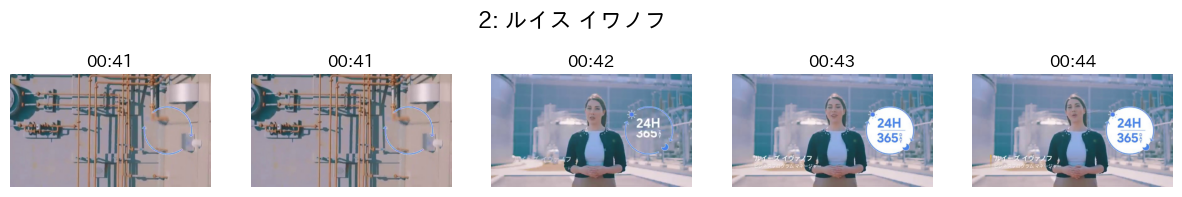

<Figure size 640x480 with 0 Axes>

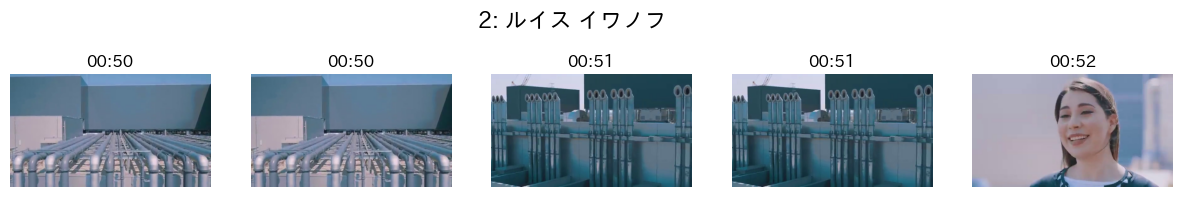

<Figure size 640x480 with 0 Axes>

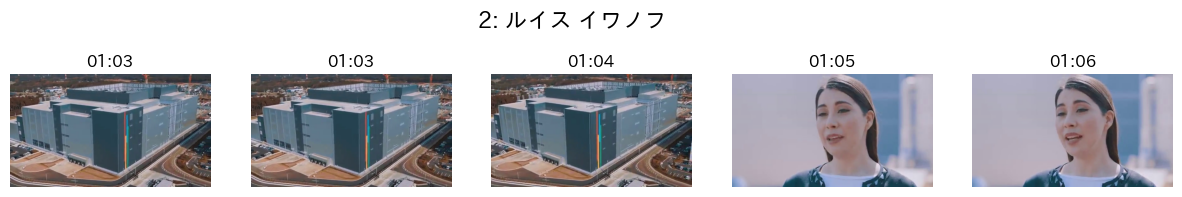

=====
3 高橋 駿 彼はアジア系の男性で、非常に特徴的な髪型をしています。髪の半分は青色、もう半分は赤色に染められています。彼は黒いTシャツを着ており、Google Cloudのロゴが入っています。彼は会議室のような場所に座っています。


<Figure size 640x480 with 0 Axes>

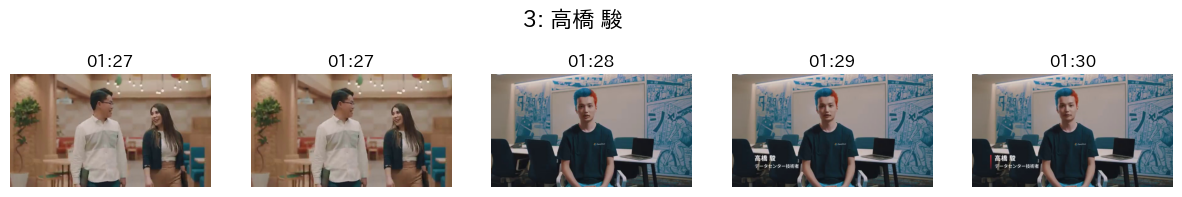

<Figure size 640x480 with 0 Axes>

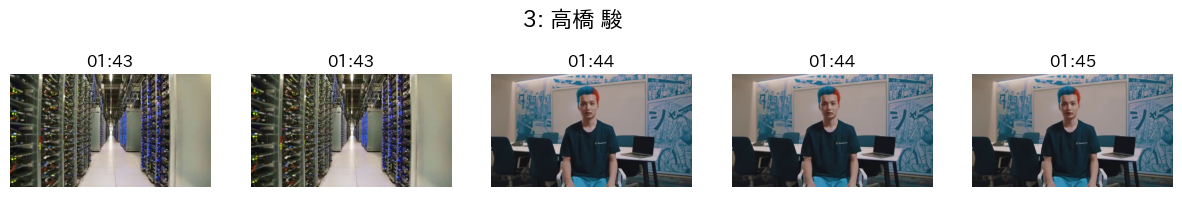

<Figure size 640x480 with 0 Axes>

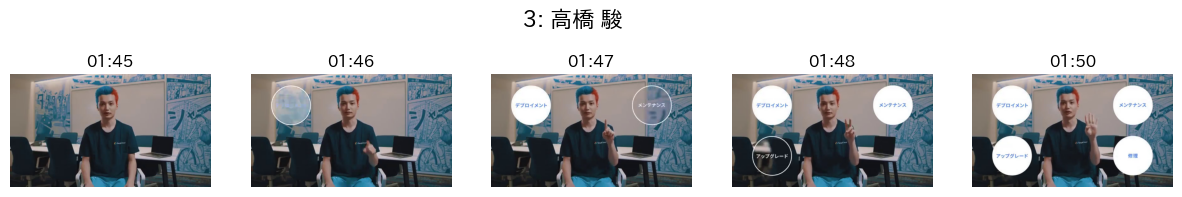

=====
4 レオ ギャラモン 彼は黒人系の男性で、短く整えられた髪と髭を持っています。彼は眼鏡をかけており、穏やかな表情をしています。彼は黒いポロシャツを着ており、胸にはロゴが入っています。彼はオフィスのような場所に立っています。


<Figure size 640x480 with 0 Axes>

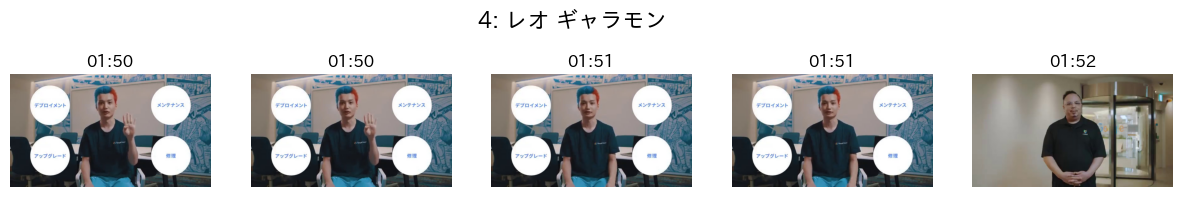

<Figure size 640x480 with 0 Axes>

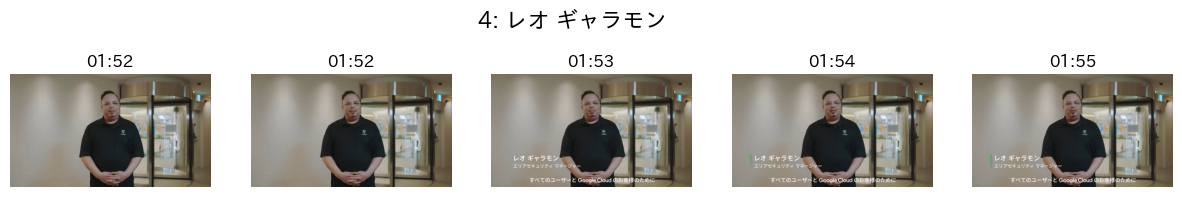

<Figure size 640x480 with 0 Axes>

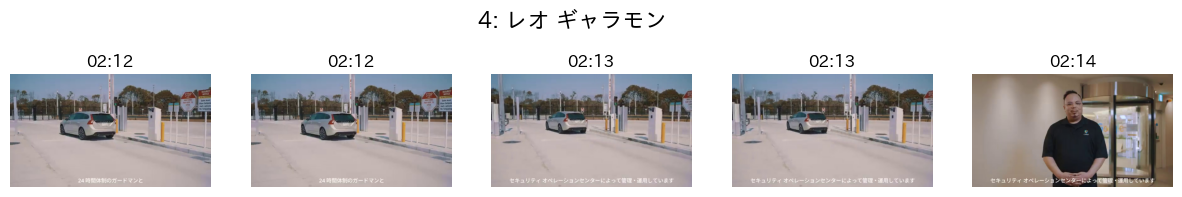

<Figure size 640x480 with 0 Axes>

In [27]:
scenes = load_json(result)
jpg_files = !ls "{local_image_dir}/"
m = 0
for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
    try:
        m = max(m, int(c))
    except:
        pass

for item in scenes:
    print('=====')
    print(item['Character ID'], item['Name'], item['Visual Description'])
    for ts in item['Scenes'][:3]:
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))  # Adjust figsize as needed
        axs = axs.ravel()
        fig.suptitle(str(item['Character ID']) + ': ' + item['Name'], fontsize=16)
        for c, ts in enumerate(np.linspace(max(1, ss1), min(ss2, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

キャラクター名はハルシネーションが起きている可能性があるので、外見の記述と参考画像を元にネット検索で正しい名前を検索して、参照用画像ファイルを別途用意

In [28]:
chars = !gsutil ls "{image_dir}/characters/*.png"
chars

['gs://movie-search-metadeta-test-handson/image/千葉県印西市にデータセンターを開設/characters/ルイーズ イヴァノフ.png',
 'gs://movie-search-metadeta-test-handson/image/千葉県印西市にデータセンターを開設/characters/レオ ギャラモン.png',
 'gs://movie-search-metadeta-test-handson/image/千葉県印西市にデータセンターを開設/characters/金井 匡彦.png',
 'gs://movie-search-metadeta-test-handson/image/千葉県印西市にデータセンターを開設/characters/高橋 駿.png']

In [32]:
prompt_reference = [
    '\n[Reference information to identify character names]'
]
image_files = {}
for item in chars:
    name = item.split('/')[-1].rstrip('.png')
    image_files[name] = item
    prompt_reference += [
        f'The name of following character is "{name}"',
        Part.from_uri(file_uri=image_files[name], mime_type='image/png')
    ]

prompt_reference

['\n[Reference information to identify character names]',
 'The name of following character is "ルイーズ イヴァノフ"',
 Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=FileData(file_uri='gs://movie-search-metadeta-test-handson/image/千葉県印西市にデータセンターを開設/characters/ルイーズ イヴァノフ.png', mime_type='image/png'), function_call=None, function_response=None, text=None),
 'The name of following character is "レオ ギャラモン"',
 Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=FileData(file_uri='gs://movie-search-metadeta-test-handson/image/千葉県印西市にデータセンターを開設/characters/レオ ギャラモン.png', mime_type='image/png'), function_call=None, function_response=None, text=None),
 'The name of following character is "金井 匡彦"',
 Part(video_metadata=None, thought=None, inline_data=None, code_execution_result=None, executable_code=None, file_data=FileData(file_uri='gs://movie-search-metadeta-te

## 動画サマリー

In [43]:
system_instruction = ''

In [44]:
prompt_summary = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Give an one sentence summary of the movie that can be used as a title of the movie.
B. Summarize the content of the movie in five to ten sentences.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
A, B. The output should be based on the objective information in the movie.

[format instruction]
Answer in Japanese. In the JSON dict with the following format:
{
  "Title": "<Output of Task A>",
  "Summary": "<Output of Task B>"
}
'''

# prompt_summary = [prompt_summary] + prompt_reference

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Title": {"type": "string",
                },
                "Summary" : {"type": "string",
                },
            },
            "required": [
                "Title",
                "Summary",
            ],

    }
}

In [45]:
contents = UserContent([
    Part.from_text(text=prompt_summary),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Title": "グーグルが千葉県印西市に建設したハイパースケールデータセンターを紹介するビデオ",
    "Summary": "このビデオでは、グーグルが千葉県印西市に建設したハイパースケールデータセンターを紹介します。金井匡彦は、データセンター建設のジャパンリードとして紹介されています。ルイーズ・イワノフは、ビジネスプログラムマネージャーとして紹介されています。高橋駿は、データセンター技術者として紹介されています。レオ・ギャラモンは、エリアセキュリティマネージャーとして紹介されています。このデータセンターは、一般的な企業のデータセンターと比較して約2倍のエネルギー効率を実現しています。また、6層のセキュリティでデータセンターを安全に保護しています。"
  }
]


In [46]:
summary = pprint.pformat(load_json(result))

## 重要シーン抽出

In [48]:
prompt_important_scenes = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find around 15 important scenes in the movie with accurate timestamps.
B. Give a short summary of each scene and why that scene is important.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
The [summary] section contains the summary of the entire movie.
You don't need to use the summary information to find scenes, but the result should be consistent with the summary.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task B>
Header is: Timestamp, Description

[summary]
''' + summary

# prompt_important_scenes = [prompt_important_scenes] + prompt_reference

In [50]:
contents = UserContent([
    Part.from_text(text=prompt_important_scenes),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

important_scenes = generate_response(system_instruction, contents, response_schema=None, model='gemini-2.0-flash-001')
print(important_scenes)

{
  "output": [
    {
      "Timestamp, Description": "00:07-00:09, 金井匡彦がデータセンター建設のジャパンリードとして紹介されるシーン。このデータセンタープロジェクトの重要人物の一人を紹介。"
    },
    {
      "Timestamp, Description": "00:11-00:13, データセンターの入り口のセキュリティゲートを通過する様子。データセンターのセキュリティ対策の厳重さを示す。"
    },
    {
      "Timestamp, Description": "00:13-00:15, データセンターの受付エリアの様子。データセンターの内部の様子を紹介。"
    },
    {
      "Timestamp, Description": "00:20-00:22, ハイパースケールデータセンターの説明。大規模なデータとクラウドコンピューティングを支える巨大でスケーラブルなデータセンターであることを説明。"
    },
    {
      "Timestamp, Description": "00:40-00:42, ルイーズ・イワノフがビジネスプログラムマネージャーとして紹介されるシーン。データセンターの運営におけるビジネス側の責任者を紹介。"
    },
    {
      "Timestamp, Description": "00:44-00:46, データセンター内のサーバー設備の様子。データセンターの中核となる設備を紹介。"
    },
    {
      "Timestamp, Description": "01:21-01:24, ルイーズ・イワノフがデータセンターのエネルギー効率について説明するシーン。一般的な企業のデータセンターと比較して約2倍のエネルギー効率であることを強調。"
    },
    {
      "Timestamp, Description": "01:27-01:29, 高橋駿がデータセンター技術者として紹介されるシーン。データセンターの技術面を支える人物を紹介。"
    },
    {
      "Timestamp, Description": "01:30-01:32, デ

## シーン情報（ビジュアル情報）取得

In [54]:
prompt_visuals = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Split the entire movie into scenes with accurate timestamps from start to the exact end of the movie file.
B. Describe what's happening in the scene as detailed as possible.
C. Enrich the output of task B by adding visual information of not only characters but also things in the background.

[condition]
A. The length of each scene is 1 to 15 seconds.
 - Good example: 00:05-00:08, 00:05-00:18. / Bad example: 00:05-01:14 as the timestamp jumps more than 15 seconds.
B, C. Avoid using audio information to describe the scene. Describle only what you see on the screen.
B. If possible, identify the names of characters. Use the full name on every part of the output.
C. The final description is very detailed, vivid and realistic to covey all the visual information of the scene, using up to three sentences.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task C>
Header is: Timestamp, Description
'''

# prompt_visuals = [prompt_visuals] + prompt_reference

In [55]:
contents = UserContent([
    Part.from_text(text=prompt_visuals),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

visual_info = generate_response(system_instruction, contents, response_schema=None, model='gemini-2.0-flash-001')
print(visual_info)

{
"output": [
{
"Timestamp": "00:00-00:07",
"Description": "金井匡彦がGoogleの看板の前に立っている。背景には、青い空と、オレンジ、黄色、緑、青の線が入った灰色の建物が見える。画面には、千葉県印西市の地図が表示されている。"
},
{
"Timestamp": "00:07-00:11",
"Description": "金井匡彦がカメラに向かって話している。背景には、青い空と、オレンジ、黄色、緑、青の線が入った灰色の建物が見える。"
},
{
"Timestamp": "00:11-00:14",
"Description": "人がGoogleのロゴが入ったガラス張りの建物に入っていく。建物は白とグレーで、空は晴れている。"
},
{
"Timestamp": "00:14-00:17",
"Description": "ロビーには、花瓶と木の絵が飾られた受付がある。部屋は白く、天井にはライトがある。"
},
{
"Timestamp": "00:17-00:25",
"Description": "データセンターの建物の航空写真。建物はグレーで、オレンジ、黄色、緑、青の線が入っている。屋上には空調設備がある。"
},
{
"Timestamp": "00:25-00:28",
"Description": "東京のスカイラインの航空写真。東京タワーと高層ビルが見える。空はオレンジと青のグラデーションになっている。"
},
{
"Timestamp": "00:28-00:30",
"Description": "女性がグラフを指しながらプレゼンテーションをしている。他の2人が座って聞いている。テーブルにはノートパソコンと植物がある。"
},
{
"Timestamp": "00:30-00:30",
"Description": "女性がノートパソコンでコーディングをしている。机の上には本とメモがある。画面にはコードが表示されている。"
},
{
"Timestamp": "00:30-00:35",
"Description": "金井匡彦がGoogleの看板の前に立っている。背景には、青い空と、オレンジ、黄色、緑、青の線が入った灰色の建物が見える。"
},
{
"Timestamp": "00

## 音声文字起こし

In [56]:
prompt_transcription = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Transcript what they are speaking with accurate timestamps.

[condition]
A. Process the entire movie from start to the exact end of the movie file.
A. Identify the name of person who is speaking for each speech. Use the full name on every part of the output. If you cannot identify the name, name it "Unknown".

[format instruction]
In Japanese. Output is a JSON list of "speech dict". "speech dict" is a JSON dict in the following format:
{
  "timestamp": "<mm:ss-mm:ss>",
  "Name": "<Name of the speaker>",
  "Transcription": "<Transcription>"
}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "timestamp": {"type": "string",
                                 "description": "<mm:ss-mm:ss>"
                },
                "Name" : {"type": "string",
                          "description": "Name of the speaker"
                },
                "Transcription": {"type": "string",
                },
            },
            "required": [
                "timestamp",
                "Name",
                "Transcription",
            ],

    }
}

In [57]:
contents = UserContent([
    Part.from_text(text=prompt_transcription),
    Part.from_uri(file_uri=target_s, mime_type='video/mp4'),
])
result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "timestamp": "00:00-00:07",
    "Name": "金井 匡彦",
    "Transcription": "2023年 Googleとしてデータセンターをここ千葉県印西市に開設しました。"
  },
  {
    "timestamp": "00:08-00:25",
    "Name": "金井 匡彦",
    "Transcription": "このデータセンターの特徴は何と言ってもGoogleデータセンターのグローバル設計基準と日本技術文化の融合にて設計されていること。そして日本で最大規模のハイパースケールデータセンターであることです。"
  },
  {
    "timestamp": "00:25-00:35",
    "Name": "金井 匡彦",
    "Transcription": "当然環境にも配慮した設計になっています。このデータセンターによって日本の企業の皆様がGoogle Cloudを含むGoogle製品をさらに快適にそして安全にお使いいただけるようになります。"
  },
  {
    "timestamp": "00:36-00:43",
    "Name": "ルイス イヴァノフ",
    "Transcription": "データセンターでは重要なインフラの運用維持を24時間365日行っています。"
  },
  {
    "timestamp": "00:44-00:51",
    "Name": "ルイス イヴァノフ",
    "Transcription": "高いパフォーマンスを維持するために電力や冷却システムの継続的な供給が必要不可欠です。"
  },
  {
    "timestamp": "00:52-01:02",
    "Name": "ルイス イヴァノフ",
    "Transcription": "地域の観光や規範に沿ったGoogle基準のメンテナンスを実行することで、世界のGoogleデータセンターと同レベルの信頼性を実現しています。"
  },
  {
    "timestamp": "01:03-01:14",
    "Name": "ルイス イヴァノフ",
    "Transcription": "またインフラを

In [58]:
transcription = pprint.pformat(load_json(result))

## テキスト情報取得

１回の処理ですべてのテキストを取得しようとすると、出力トークン数の上限に達するので、はじめにテキストが存在するシーンの情報を取得する。

In [100]:
prompt_text_layout = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Identify scenes where text strings are on the screen.
B. Describe the layout only focusing on how text strings are arranged on the screen (e.g. "画面左下に縦書きで2つのテキストブロックが配置されている"), avoid including text information itself.

[conditions]
Process the entire movie from start to the exact end of the movie file.

[format instruction]
Layout description is in Japanese.
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Layout": "<layout description from Task B>"
}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Timestamp": {"type": "string",
                              "description": "<Timestamp mm:ss-mm:ss>"
                },
                "Layout" : {"type": "string",
                            "description": "layout description from Task B"
                },
            },
            "required": [
                "Timestamp",
                "Layout",
            ],

    }
}

In [101]:
# result = generate(prompt_text_layout, model=model_noaudio)

contents = UserContent([
    Part.from_text(text=prompt_text_layout),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])
result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:06-00:07",
    "Layout": "画面左下に、地図の近くにテキストブロックが配置されている"
  },
  {
    "Timestamp": "00:08-00:10",
    "Layout": "画面左下に、3行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "00:20-00:21",
    "Layout": "画面下に一行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "00:41-00:42",
    "Layout": "画面左下に、3行のテキストブロックが配置されている。画面右中央に円形のテキストブロックが配置されている"
  },
  {
    "Timestamp": "01:22-01:24",
    "Layout": "画面左上に、2つのテキストブロックが縦に配置されている。画面下に一行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "01:27-01:29",
    "Layout": "画面左下に、2行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "01:44-01:49",
    "Layout": "画面中央の人物の左右に、円形のテキストブロックが複数配置されている"
  },
  {
    "Timestamp": "01:51-01:54",
    "Layout": "画面左下に、3行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "01:55-01:59",
    "Layout": "画面下に一行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "01:59-02:02",
    "Layout": "画面下に一行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:03-02:07",
    "Layout": "画面下に一行のテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:08-02

In [102]:
layout_info = load_json(result)

In [103]:
layout_info

[{'Timestamp': '00:06-00:07', 'Layout': '画面左下に、地図の近くにテキストブロックが配置されている'},
 {'Timestamp': '00:08-00:10', 'Layout': '画面左下に、3行のテキストブロックが配置されている'},
 {'Timestamp': '00:20-00:21', 'Layout': '画面下に一行のテキストブロックが配置されている'},
 {'Timestamp': '00:41-00:42',
  'Layout': '画面左下に、3行のテキストブロックが配置されている。画面右中央に円形のテキストブロックが配置されている'},
 {'Timestamp': '01:22-01:24',
  'Layout': '画面左上に、2つのテキストブロックが縦に配置されている。画面下に一行のテキストブロックが配置されている'},
 {'Timestamp': '01:27-01:29', 'Layout': '画面左下に、2行のテキストブロックが配置されている'},
 {'Timestamp': '01:44-01:49', 'Layout': '画面中央の人物の左右に、円形のテキストブロックが複数配置されている'},
 {'Timestamp': '01:51-01:54', 'Layout': '画面左下に、3行のテキストブロックが配置されている'},
 {'Timestamp': '01:55-01:59', 'Layout': '画面下に一行のテキストブロックが配置されている'},
 {'Timestamp': '01:59-02:02', 'Layout': '画面下に一行のテキストブロックが配置されている'},
 {'Timestamp': '02:03-02:07', 'Layout': '画面下に一行のテキストブロックが配置されている'},
 {'Timestamp': '02:08-02:11', 'Layout': '画面下に一行のテキストブロックが配置されている'},
 {'Timestamp': '02:12-02:13', 'Layout': '画面下に一行のテキストブロックが配置されている'},
 {'Timestamp': '02:15-02:21', 'Layo

取得した情報から５シーンごとに分割してテキストを抽出する。

In [106]:
prompt_texts = '''\
You are a video content editor. Work on the following tasks.

[task]
A. The [text layout] contains scenes where text strings are on the screen in JSON list.
Extract exact text strings from each scene by repeating the [steps].

[steps]
1. Take the next "text dict" item from the [text layout].
2. Extract text strings from the scene specified by the "Timestamp" and "Layout".
3. Output the new "text dict" that have the "Text" element. "Timestamp" and "Layout" should be the same as the original item.

[condition]
A. <IMPORTANT> Process the scenes only within the timestamps described in the [text layout]. Hence the "Timestamp" in the output should be the same as in the [text layout].
A. Output each character literally as on the screen. Don't modify them.
A. Use a list to store multiple lines of texts instead of using the return code \\n in the extracted text strings.
A. Make sure to use double quotes "" in the output JSON.

[format instruction]
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Text": [List of text strings from Task A>],
  "Layout": "<layout description>"
}

[text layout]
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Timestamp": {"type": "string",
                              "description": "<Timestamp mm:ss-mm:ss>"
                },
                "Text": {"type": "array",
                           "items": {
                              "type": "string"
                           },
                           "description": "List of text strings from Task A>"
                },
                "Layout" : {"type": "string",
                            "description": "<layout description>"
                },
            },
            "required": [
                "Timestamp",
                "Text",
                "Layout",
            ],

    }
}

In [ ]:
contents = UserContent([
    Part.from_text(text=prompt_texts),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

merged_result = []
for c in range(0, len(layout_info), 5):
    print(f'\n=== Scene {c+1} to {c+5} ===')
    prompt = prompt_texts + pprint.pformat(layout_info[c:c+5])
    print(pprint.pformat(layout_info[c:c+5]))
    # 正しい JSON が出力されないなどで処理エラーが発生した場合は2回リトライする。
    n = 0
    while n < 2:
        try:
            result = generate_response(system_instruction, contents,
                                       response_schema=response_schema,
                                       model='gemini-2.0-flash-001'
                                       # model='gemini-2.5-flash-preview-05-20'
                                      )
            print(result)
            merged_result += load_json(result)
            break
        except Exception as e:
            print(e)
            n += 1
            pass
texts = pprint.pformat(merged_result)

In [110]:
merged_result

[{'Timestamp': '00:06-00:07', 'Text': ['千葉県 印西市'], 'Layout': 'location name'},
 {'Timestamp': '00:08-00:10',
  'Text': ['金井 匡彦', 'データセンター建設', 'ジャパンリード'],
  'Layout': 'name and job title'},
 {'Timestamp': '00:40-00:43', 'Text': ['24H', '365DAY'], 'Layout': '24/7'},
 {'Timestamp': '00:41-00:43',
  'Text': ['ルィーズ イヴァノフ', 'ビジネスプログラム マネージャー'],
  'Layout': 'name and job title'},
 {'Timestamp': '01:22-01:24',
  'Text': ['約 2 倍の', 'エネルギー効率', '一般的な企業のデータセンターとの比較'],
  'Layout': 'energy efficiency'},
 {'Timestamp': '01:27-01:29',
  'Text': ['高橋 駿', 'データセンター技術者'],
  'Layout': 'name and job title'},
 {'Timestamp': '01:44-01:49',
  'Text': ['デプロイメント', 'メンテナンス', 'アップグレード', '修理'],
  'Layout': 'deployment, maintenance, upgrade, repair'},
 {'Timestamp': '01:51-01:54',
  'Text': ['レオ ギャラモン', 'エリアセキュリティ マネージャー', 'すべてのユーザーと Google Cloud のお客様のために'],
  'Layout': 'name and job title'},
 {'Timestamp': '01:55-01:59',
  'Text': ['私たちは6層のセキュリティでデータセンターを安全に保護しています'],
  'Layout': 'security description'},
 {'Timesta

## テキストベースの動画内検索

In [115]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>",
  "Evidence": [<List of data snippets that support your result>]
}}

[user query]
{}

[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Timestamp": {"type": "string",
                              "description": "<Timestamp mm:ss-mm:ss>"
                },
                "Description" : {"type": "string",
                            "description": "Explain how this scene matches the query."
                },
                "Evidence": {"type": "array",
                             "items": {
                                 "type": "string"
                             },
                             "description": "List of data snippets that support your result>"
                },
            },
            "required": [
                "Timestamp",
                "Description",
                "Evidence"
            ],

    }
}

In [116]:
def show_thumbnails(scenes):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2))  # Adjust figsize as needed
        axs = axs.ravel()
        print('=====')
        print(str(item['Description']))
        # 報告されたタイムスタンプの前後 3 秒を含めて 5 枚の静止画像を表示する
        for c, ts in enumerate(np.linspace(max(1, ss1-3), min(ss2+3, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [117]:
%%time
query = 'サーバーのメンテナンスについて解説しているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
# result = generate(prompt, model=model_flash)

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])
result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:36-00:43",
    "Description": "データセンターでは重要なインフラの運用維持を24時間365日行っていることについて解説しているシーンです。",
    "Evidence": [
      "ルイス イヴァノフ: データセンターでは重要なインフラの運用維持を24時間365日行っています。",
      "データセンターでは重要なインフラの運用維持を24時間365日行っています。"
    ]
  },
  {
    "Timestamp": "01:43-01:50",
    "Description": "全てのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行っていることについて解説しているシーンです。",
    "Evidence": [
      "高橋 駿: また全てのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行っています。",
      "また全てのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行っています。"
    ]
  }
]
CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 6.22 s


=====
データセンターでは重要なインフラの運用維持を24時間365日行っていることについて解説しているシーンです。


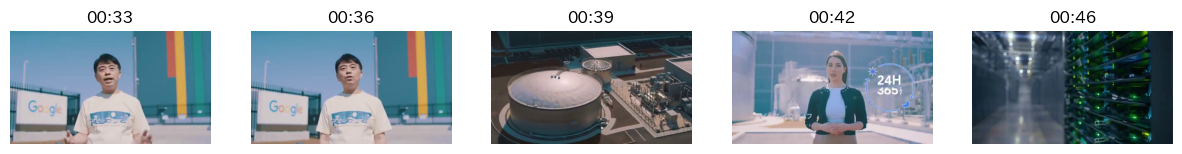

=====
全てのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行っていることについて解説しているシーンです。


<Figure size 640x480 with 0 Axes>

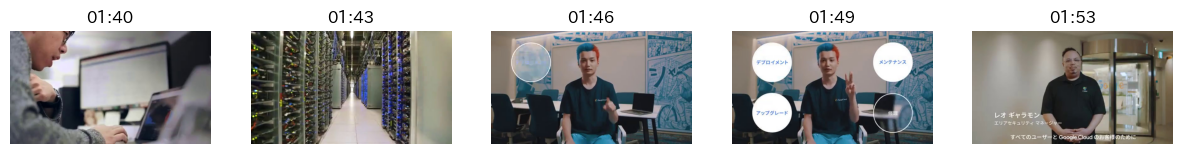

<Figure size 640x480 with 0 Axes>

In [118]:
show_thumbnails(load_json(result))

In [122]:
%%time
query = '金井さんが登場するシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:00-00:07",
    "Description": "金井匡彦がグーグルの看板の前に立って、データセンターについて紹介するシーンです。",
    "Evidence": [
      "金井 匡彦: 2023年 Googleとしてデータセンターをここ千葉県印西市に開設しました。",
      "金井匡彦がGoogleの看板の前に立っている。"
    ]
  },
  {
    "Timestamp": "00:07-00:09",
    "Description": "金井匡彦がデータセンター建設のジャパンリードとして紹介されるシーンです。",
    "Evidence": [
      "00:07-00:09, 金井匡彦がデータセンター建設のジャパンリードとして紹介されるシーン。このデータセンタープロジェクトの重要人物の一人を紹介。",
      "金井 匡彦\nデータセンター建設\nジャパンリード"
    ]
  },
  {
    "Timestamp": "02:22-02:24",
    "Description": "金井匡彦が再び登場し、データセンターの重要性を語るシーンです。",
    "Evidence": [
      "02:22-02:24, 金井匡彦が再び登場し、データセンターの重要性を語るシーン。プロジェクトの締めくくりとして、データセンターの意義を再確認。",
      "金井匡彦がGoogleの看板の前に立っている。"
    ]
  }
]
CPU times: user 32.2 ms, sys: 0 ns, total: 32.2 ms
Wall time: 6.92 s


=====
金井匡彦がグーグルの看板の前に立って、データセンターについて紹介するシーンです。


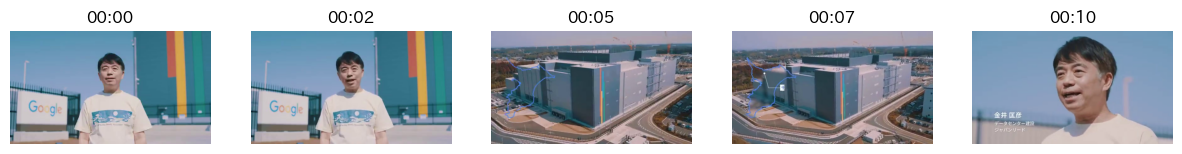

=====
金井匡彦がデータセンター建設のジャパンリードとして紹介されるシーンです。


<Figure size 640x480 with 0 Axes>

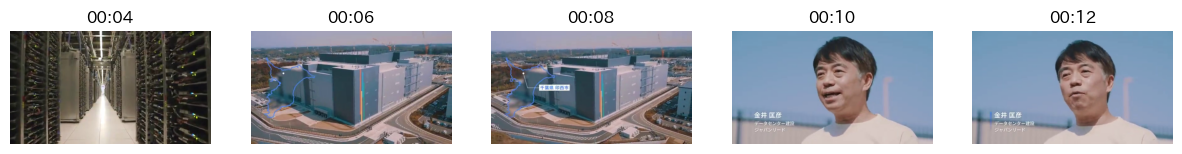

=====
金井匡彦が再び登場し、データセンターの重要性を語るシーンです。


<Figure size 640x480 with 0 Axes>

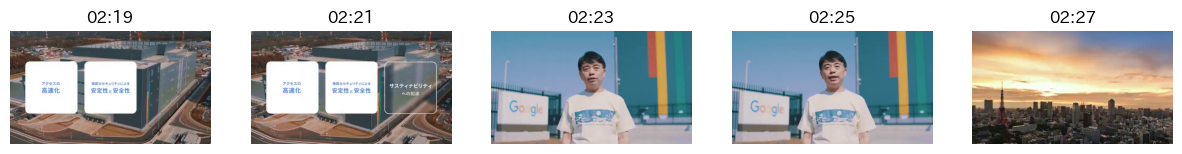

<Figure size 640x480 with 0 Axes>

In [123]:
show_thumbnails(load_json(result))

In [126]:
%%time
query = 'データセンター内部が写ってるシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:13-00:15",
    "Description": "データセンターの受付エリアが写っているシーンです。受付の様子からデータセンター内部の様子を知ることができます。",
    "Evidence": [
      "データセンターの受付エリアの様子。データセンターの内部の様子を紹介。",
      "ロビーには、花瓶と木の絵が飾られた受付がある。部屋は白く、天井にはライトがある。"
    ]
  },
  {
    "Timestamp": "00:43-00:45",
    "Description": "データセンター内のサーバー設備の様子が写っているシーンです。サーバーが並び、データセンターの中核となる設備であることがわかります。",
    "Evidence": [
      "データセンター内のサーバー設備の様子。データセンターの中核となる設備を紹介。",
      "データセンターのサーバーのクローズアップ。サーバーはグレーで、緑と青のライトが点滅している。ケーブルがたくさんある。"
    ]
  },
  {
    "Timestamp": "01:30-01:32",
    "Description": "データセンター内のサーバー設備の詳細な様子が写っているシーンです。サーバーが整然と並び、データセンターの中核となる設備であることがわかります。",
    "Evidence": [
      "データセンター内のサーバー設備の詳細な様子。データセンターの中核となる設備を紹介。",
      "データセンターのサーバーの航空写真。サーバーはグレーで、ケーブルがたくさんある。天井にはライトがある。"
    ]
  }
]
CPU times: user 21.6 ms, sys: 6.82 ms, total: 28.4 ms
Wall time: 6.1 s


=====
データセンターの受付エリアが写っているシーンです。受付の様子からデータセンター内部の様子を知ることができます。


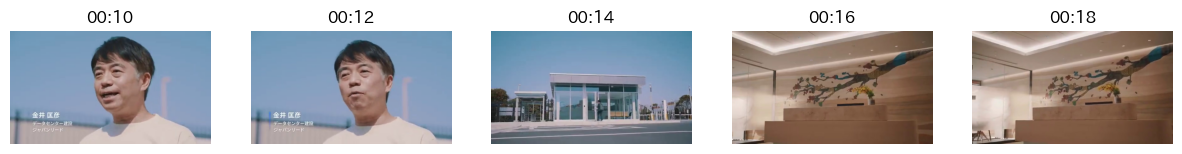

=====
データセンター内のサーバー設備の様子が写っているシーンです。サーバーが並び、データセンターの中核となる設備であることがわかります。


<Figure size 640x480 with 0 Axes>

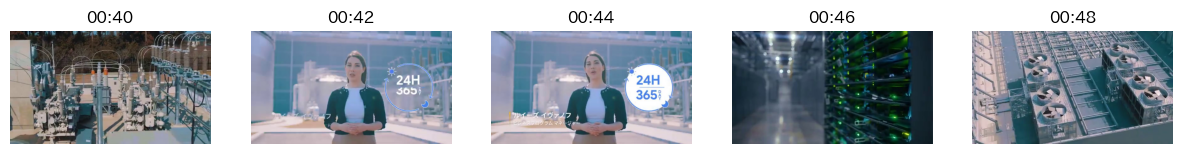

=====
データセンター内のサーバー設備の詳細な様子が写っているシーンです。サーバーが整然と並び、データセンターの中核となる設備であることがわかります。


<Figure size 640x480 with 0 Axes>

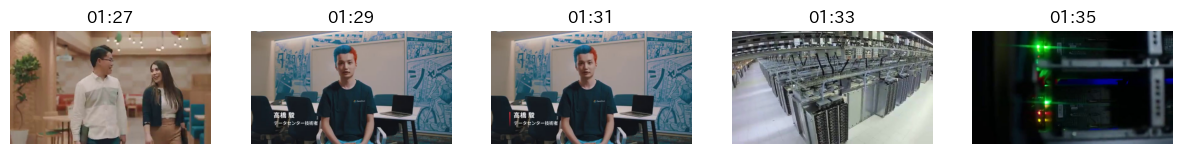

<Figure size 640x480 with 0 Axes>

In [127]:
show_thumbnails(load_json(result))

## 動画ベースの動画内検索

In [131]:
prompt_movie_content_search = '''\
You are a video content editor.
Find one to three scenes that matches the user query with timestamps.

[condition]
Try to identify names of characters.
The result should be based on the objective information in the movie itself.

[user query]
{}

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Timestamp": {"type": "string",
                              "description": "<Timestamp mm:ss-mm:ss>"
                },
                "Description" : {"type": "string",
                            "description": "Explain how this scene matches the query."
                },
            },
            "required": [
                "Timestamp",
                "Description"
            ],

    }
}

In [134]:
%%time
query = 'サーバーのメンテナンスについて解説しているシーン'
prompt = prompt_movie_content_search.format(query)
# prompt = [prompt] + prompt_reference

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "01:43-01:49",
    "Description": "高橋駿が、サーバーのメンテナンスについて解説しています。"
  }
]
CPU times: user 26.4 ms, sys: 3.58 ms, total: 30 ms
Wall time: 4.36 s


=====
データセンター技術者の高橋駿が、サーバーのメンテナンスについて解説しています。


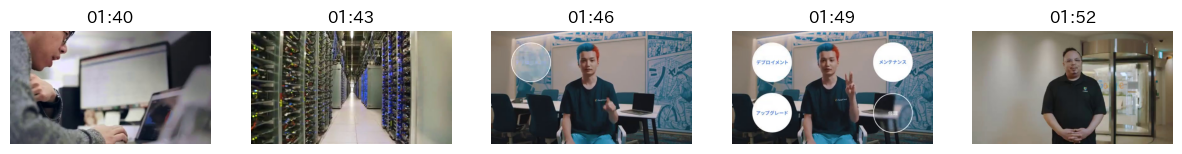

<Figure size 640x480 with 0 Axes>

In [133]:
show_thumbnails(load_json(result))

In [137]:
%%time
query = '金井さんが登場するシーン'
prompt = prompt_movie_content_search.format(query)
# prompt = [prompt] + prompt_reference
contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:00-00:10",
    "Description": "金井匡彦さんがGoogleの看板の前で話しているシーン。"
  },
  {
    "Timestamp": "02:22-02:24",
    "Description": "金井匡彦さんがGoogleの看板の前で話しているシーン。"
  }
]
CPU times: user 30.4 ms, sys: 0 ns, total: 30.4 ms
Wall time: 5.41 s


=====
金井匡彦さんがGoogleの看板の前で話しているシーン。


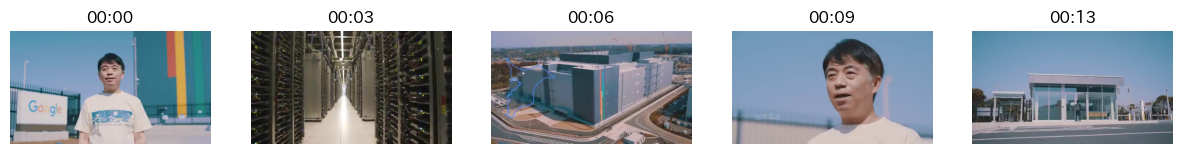

=====
金井匡彦さんがGoogleの看板の前で話しているシーン。


<Figure size 640x480 with 0 Axes>

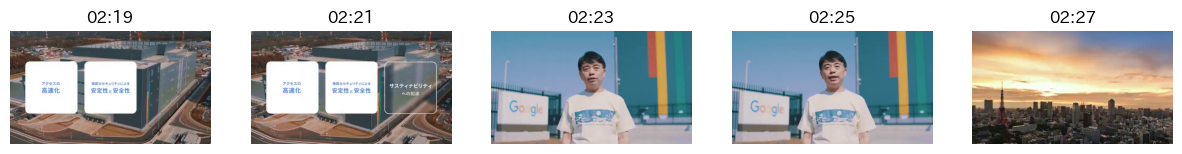

<Figure size 640x480 with 0 Axes>

In [138]:
show_thumbnails(load_json(result))

In [139]:
%%time
query = 'SNS投稿に適した映えるシーン'
prompt = prompt_movie_content_search.format(query)
# prompt = [prompt] + prompt_reference
contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:00-00:00",
    "Description": "金井匡彦氏がGoogleの看板の前で話しているシーン。背景の色使いも鮮やか。"
  },
  {
    "Timestamp": "00:14-00:17",
    "Description": "受付の装飾が美しく、目を引くデザイン。"
  },
  {
    "Timestamp": "00:41-00:43",
    "Description": "ルイーズ・イヴァノフ氏がデータセンターの設備を背景に話しているシーン。清潔感と技術力が伝わる。"
  },
  {
    "Timestamp": "01:27-01:29",
    "Description": "高橋駿氏の髪色が印象的で、背景の壁画もユニーク。"
  }
]
CPU times: user 29.5 ms, sys: 0 ns, total: 29.5 ms
Wall time: 6.11 s


=====
Google データセンター建設 ジャパンリードの金井 匡彦さんが Google データセンターを紹介するシーンです。Google のロゴとデータセンターの外観が映えるシーンです。


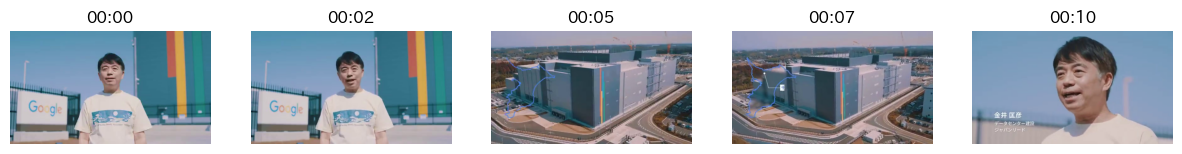

=====
Google データセンターで働く社員が談笑しながら歩いているシーンと、データセンターのサーバー群が映えるシーンです。最先端で働く様子が伺えます。


<Figure size 640x480 with 0 Axes>

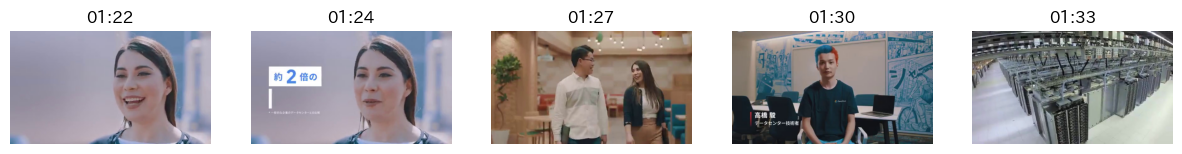

=====
エリアセキュリティマネージャーのレオ ギャラモンさんがセキュリティについて説明しているシーンです。近未来的なセキュリティシステムが映えるシーンです。


<Figure size 640x480 with 0 Axes>

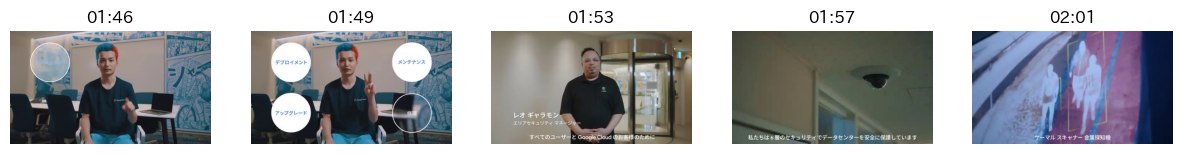

<Figure size 640x480 with 0 Axes>

In [83]:
show_thumbnails(load_json(result))

## 検索用メタテキストを保存

In [140]:
meta_text = '''\
[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}'''.format(summary, important_scenes, visual_info, transcription, texts)

metafile = f'{basename}.txt'
with open(metafile, 'w') as f:
    f.write(meta_text)

In [141]:
!gsutil cp "{metafile}" {BUCKET}/metadata/

Copying file://千葉県印西市にデータセンターを開設.txt [Content-Type=text/plain]...
/ [1 files][ 24.6 KiB/ 24.6 KiB]                                                
Operation completed over 1 objects/24.6 KiB.                                     


In [144]:
print(meta_text)

[summary]
[{'Summary': 'このビデオでは、グーグルが千葉県印西市に建設したハイパースケールデータセンターを紹介します。金井匡彦は、データセンター建設のジャパンリードとして紹介されています。ルイーズ・イワノフは、ビジネスプログラムマネージャーとして紹介されています。高橋駿は、データセンター技術者として紹介されています。レオ・ギャラモンは、エリアセキュリティマネージャーとして紹介されています。このデータセンターは、一般的な企業のデータセンターと比較して約2倍のエネルギー効率を実現しています。また、6層のセキュリティでデータセンターを安全に保護しています。',
  'Title': 'グーグルが千葉県印西市に建設したハイパースケールデータセンターを紹介するビデオ'}]

[important scenes]
{
  "output": [
    {
      "Timestamp, Description": "00:07-00:09, 金井匡彦がデータセンター建設のジャパンリードとして紹介されるシーン。このデータセンタープロジェクトの重要人物の一人を紹介。"
    },
    {
      "Timestamp, Description": "00:11-00:13, データセンターの入り口のセキュリティゲートを通過する様子。データセンターのセキュリティ対策の厳重さを示す。"
    },
    {
      "Timestamp, Description": "00:13-00:15, データセンターの受付エリアの様子。データセンターの内部の様子を紹介。"
    },
    {
      "Timestamp, Description": "00:20-00:22, ハイパースケールデータセンターの説明。大規模なデータとクラウドコンピューティングを支える巨大でスケーラブルなデータセンターであることを説明。"
    },
    {
      "Timestamp, Description": "00:40-00:42, ルイーズ・イワノフがビジネスプログラムマネージャーとして紹介されるシーン。データセンターの運営におけるビジネス側の責任者を紹介。"
    },
    {
      "Timestamp, Descri